XRF detection limits
========
Some theoretical considerations can be found [here](detectionlimits.ipynb).

Define the [materials](materials.ipynb) that could be in your sample:

In [1]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types

components = {}
k = compoundfromname.compoundfromname("linseed oil")
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Al2O3",density=4.02)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("SiO2",density=2.66)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCO3",density=2.71)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaSO4(H2O)2",density=2.31)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Fe3(PO4)2(H2O)8",density=2.65)
components[k] = 1

mix1 = mixture.Mixture(list(components.keys()),
                       list(components.values()),
                       types.fraction.mass,
                       name="Mixture1")

components = {}
k = compoundfromformula.CompoundFromFormula("PbSO4",density=2.65)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCl2",density=2.15)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CeO2",density=7.22)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("TiO2",density=4.23)
components[k] = 1

mix2 = mixture.Mixture(list(components.keys()),
                       list(components.values()),
                       types.fraction.mass,
                       name="Mixture2")

Define the XRF geometry:

In [2]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",
                                 detectorposition=-20.,
                                 detector=detector,
                                 source=source)

Create a sample in this geometry:

In [3]:
# thickness in cm
sample = multilayer.Multilayer(material=[mix1,mix2],
                               thickness=[10*1e-4,10*1e-4],
                               geometry = geometry)

Select fluorescence lines for which to calculate SNR:

In [4]:
from spectrocrunch.materials import xrayspectrum
from spectrocrunch.utils import instance

def getfluolines(ele,emin,emax):
    lines = xrayspectrum.FluoLine.factory(energybounds=(ele,emin,emax))
    return ["{}-{}".format(ele,line) for line in lines]

# Define by name:
#lines = [["Al-K"],["S-KL"],["Ce"]]

# Define by element and energy-range
lines = [getfluolines("Al",1,2),
         getfluolines("S",2,3),
         getfluolines("Ce",4.5,6.5)]

Define acquisition parameters:

In [5]:
energy = 7.5 # keV
flux = 1e10 # ph/s
time = 1 # s

Define XRF background:

In [6]:
detector.bstail = True
detector.bstep = True
bkgfluxmax = 10 # ph/s/channel
bkgenergymin = 1.
bkgenergymax = bkgenergymin + (energy-bkgenergymin)*0.5
bkgenergyw = bkgfluxmax*time/(bkgenergymin-bkgenergymax)**2
backfunc = lambda x: np.clip(bkgfluxmax*time-bkgenergyw*(x-bkgenergymax)**2,0,None)
#backfunc = None

detector.stailslope_ratio = 0.1
detector.stailarea_ratio = 0.05

Some helper functions:

In [7]:
# Function to calculate + plot
def SNR(sample,lines,plotlines=False):
    if instance.isstring(lines):
        lines = [lines]
    spectrum = sample.xrayspectrum(energy,emin=0.5,emax=energy+0.5)
    linevalid = lambda ln: any(ln.startswith(line) for line in lines)
    ret = spectrum.snr(linevalid,fluxtime=flux*time,histogram=True,backfunc=backfunc,plot=True,kstd=3)
    
    if plotlines:
        spectrum.plot(fluxtime=flux*time,histogram=True,backfunc=backfunc,\
                  forcelines=True,title=None,legend=False,ylog=True)
    else:
        plt.gca().set_yscale('log', base=10)
        
    plt.ylim((1,1e5))
    #plt.xlim((1,3))
    return ret

# Print composition
def printcomp(comp,unit="ppm"):
    if unit=="ppm":
        nfrac = comp.molefractions()
        printfmt = lambda k,v: "{}: {} ppm".format(k,v/s*1e6)
    elif unit=="wt%":
        nfrac = comp.massfractions()
        printfmt = lambda k,v: "{}: {} wt%".format(k,v/s*1e2)
    elif unit=="ug/g":
        nfrac = comp.massfractions()
        printfmt = lambda k,v: "{}: {} ug/g".format(k,v/s*1e6)
    s = sum(nfrac.values())
    print(comp.name)
    for k,v in nfrac.items():
        print(printfmt(k,v))

Calculate + visualize SNR:

Multilayer (ordered top-bottom):
 Layer 0. 10.0 um (16.67 wt% (linseed oil) + 16.67 wt% Al2O3 + 16.67 wt% SiO2 + 16.67 wt% CaCO3 + 16.67 wt% CaSO4(H2O)2 + 16.67 wt% Fe3(PO4)2(H2O)8)
 Layer 1. 10.0 um (25.00 wt% PbSO4 + 25.00 wt% CaCl2 + 25.00 wt% CeO2 + 25.00 wt% TiO2)
Mixture1
C: 14.98355393303725 wt%
H: 2.7765138603808293 wt%
O: 44.34750362655602 wt%
Al: 8.818913086129095 wt%
Si: 7.791091141066177 wt%
Ca: 10.553428913223115 wt%
S: 3.104129159649225 wt%
Fe: 5.566408196623278 wt%
P: 2.0584580833349944 wt%
Mixture2
Pb: 17.080750461619626 wt%
S: 2.643596676338697 wt%
O: 19.935818538549963 wt%
Ca: 9.027027027027025 wt%
Cl: 15.97297297297297 wt%
Ce: 20.352349968047402 wt%
Ti: 14.987484355444302 wt%


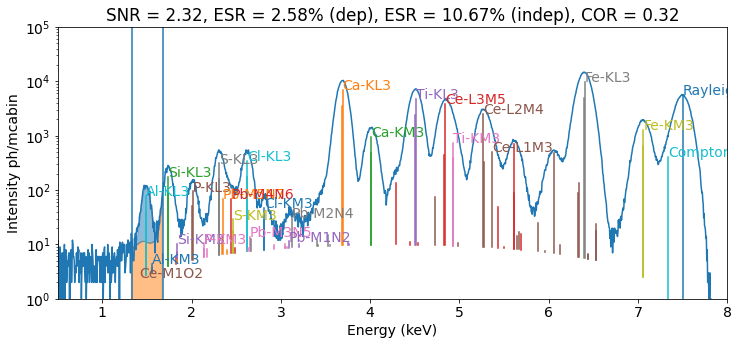

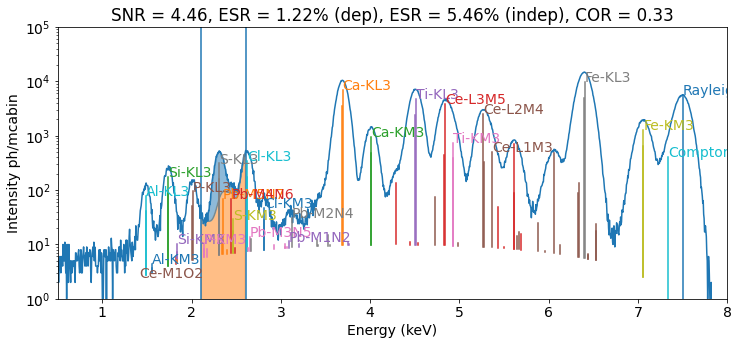

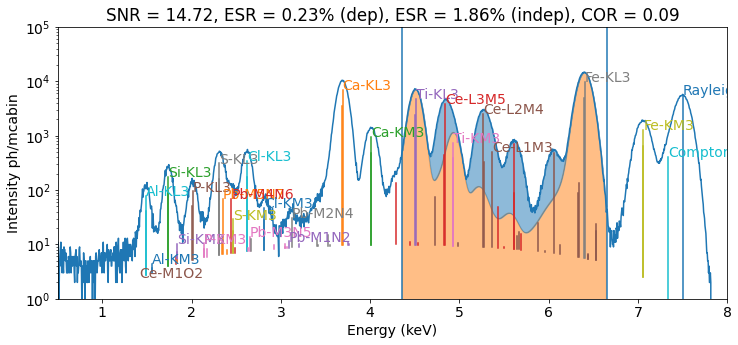

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

# Last-minute changes in composition
#mix1.setmassfraction(["Al2O3","CaSO4(H2O)2"],[0.1,0.05,0.0001])
#mix2.setmassfraction(["PbSO4","CeO2","TiO2"],[0.5,0.005,0.001])

# Print the sample composition
print(sample)

unit = "wt%"
for layer in sample:
    try:
        printcomp(layer.tocompound(name=layer.material.name),unit=unit)
    except:
        printcomp(layer.material,unit=unit)

# Calculate + plot SNR for each line
for line in lines:
    plt.figure(figsize=(12,5))
    result = SNR(sample,line,plotlines=True)
    plt.show()